In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.task_switching.hooks as hooks
from multitask.models.task_switching.models import get_task_model
from multitask.representations import get_mean_activations, calculate_rdm, plot_rdm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
path_data = os.path.join('..', '..', 'data')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [3]:
path_figure = os.path.join('svg', 'figureS18_rdm_task_switching.svg')

path_pickle_2 = os.path.join('pickle', 'task_switching_2.pickle')
path_pickle_5 = os.path.join('pickle', 'task_switching_5.pickle')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
idxs_contexts = list(range(len(num_hidden)))
num_tasks = len(tasks_names)

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_18_47)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [7]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [9]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
list_rdm_2 = []
mean_activations_2 = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)
    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)
    list_rdm_2.append(rdm_dict)
    mean_activations_2.append(mean_activations)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
initial_seed = 9876
tasks_names = ['parity', 'value', 'prime', 'fibonacci', 'multiples3']

parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': idxs_contexts
}

data_folder = check_runs(path_model_task_switching, parameters)

Found simulation in ../../results/task_switching with the same parameters (2024-01-19_16-11-23)


In [11]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_task_switching = pickle.load(handle)

In [12]:
seeds = sorted(list(results_task_switching.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[35826, 71651, 115238, 116103, 120635, 134969, 251708, 599912, 613403, 791925]
['parity', 'value', 'prime', 'fibonacci', 'multiples3']


In [13]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0, 0, 0, 0]
value: [0, 1, 0, 0, 0]
prime: [0, 0, 1, 0, 0]
fibonacci: [0, 0, 0, 1, 0]
multiples3: [0, 0, 0, 0, 1]


In [14]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
list_rdm_5 = []
mean_activations_5 = []

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_task_switching[seed]['model']
    model = get_task_model(task_switching_tasks,
                           num_hidden,
                           idxs_contexts,
                           device)
    model.load_state_dict(state_dict)
    
    indices = results_task_switching[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    _, test_dataloaders = dataset.create_dict_dataloaders(task_switching_tasks,
                                                          indices,
                                                          batch_size=batch_size)
    tasks_testloader = dataset.SequentialTaskDataloader(test_dataloaders)

    numbers = test_dataloaders[tasks_names[0]].dataset.numbers.numpy()
    numbers = numbers[indices['test']]

    _, activations = hooks.get_layer_activations(model,
                                                tasks_testloader,
                                                criterion,
                                                device=device,
                                                disable=True)
    mean_activations = get_mean_activations(activations,
                                            num_hidden,
                                            list_labels=numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)
    list_rdm_5.append(rdm_dict)
    mean_activations_5.append(mean_activations)

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

In [15]:
parent_pickle = os.path.dirname(path_pickle_2)

if not os.path.exists(parent_pickle):
    os.makedirs(parent_pickle)

with open(path_pickle_2, 'wb') as f:
    pickle.dump(mean_activations_2, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(path_pickle_5, 'wb') as f:
    pickle.dump(mean_activations_5, f, protocol=pickle.HIGHEST_PROTOCOL)

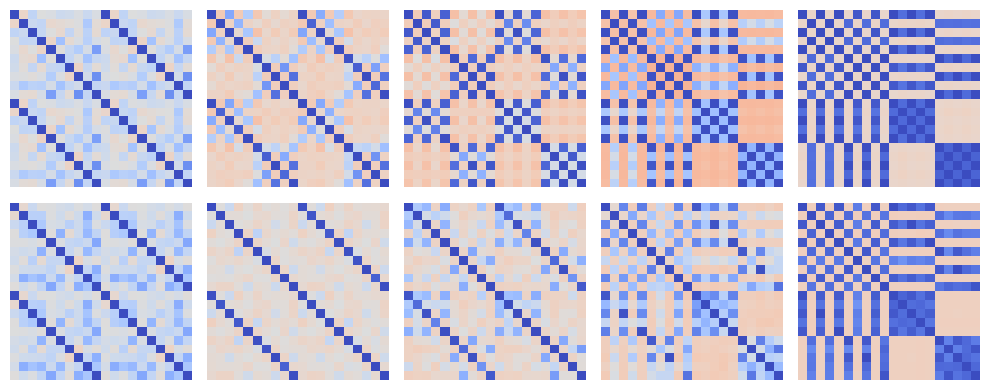

In [16]:
mean_rdm_2 = {}
mean_rdm_5 = {}

for layer in range(num_layers):
    mean_rdm_2[layer+1] = np.zeros((20, 20))
    for rdm in list_rdm_2:
        mean_rdm_2[layer+1] += rdm[layer+1]
    mean_rdm_2[layer+1] /= num_runs

for layer in range(num_layers):
    mean_rdm_5[layer+1] = np.zeros((20, 20))
    for rdm in list_rdm_5:
        mean_rdm_5[layer+1] += rdm[layer+1][:20, :20]
    mean_rdm_5[layer+1] /= num_runs


fig, ax = plt.subplots(2, num_layers, figsize=(2 * num_layers, 4))
plot_rdm(ax[0], mean_rdm_2, num_hidden, cmap='coolwarm', vmin=0, vmax=1)
plot_rdm(ax[1], mean_rdm_5, num_hidden, cmap='coolwarm', vmin=0, vmax=1)
fig.tight_layout()
fig.savefig(path_figure)
plt.show()